In [265]:
import numpy as np
import matplotlib.pylab as plt
from astropy.io import fits
from glob import glob
import re

import ugradio

Error loading librtlsdr. Make sure librtlsdr (and all of its dependencies) are in your path


In [86]:
LO = 635 * 1e6 # Hz

# Calibration

In [87]:
cal_data_dir = '../data/cal_data/'
sorted_files = np.sort(glob(f'{cal_data_dir}*'))
sorted_files = np.array(sorted_files)

In [88]:
diode_on_files = sorted_files[np.array([re.findall('.*ON.*', f) != [] for f in sorted_files])]
diode_off_files = sorted_files[np.array([re.findall('.*OFF.*', f) != [] for f in sorted_files])]

In [89]:
i = 0
diode_on = fits.open(diode_on_files[i])
diode_off = fits.open(diode_off_files[i])

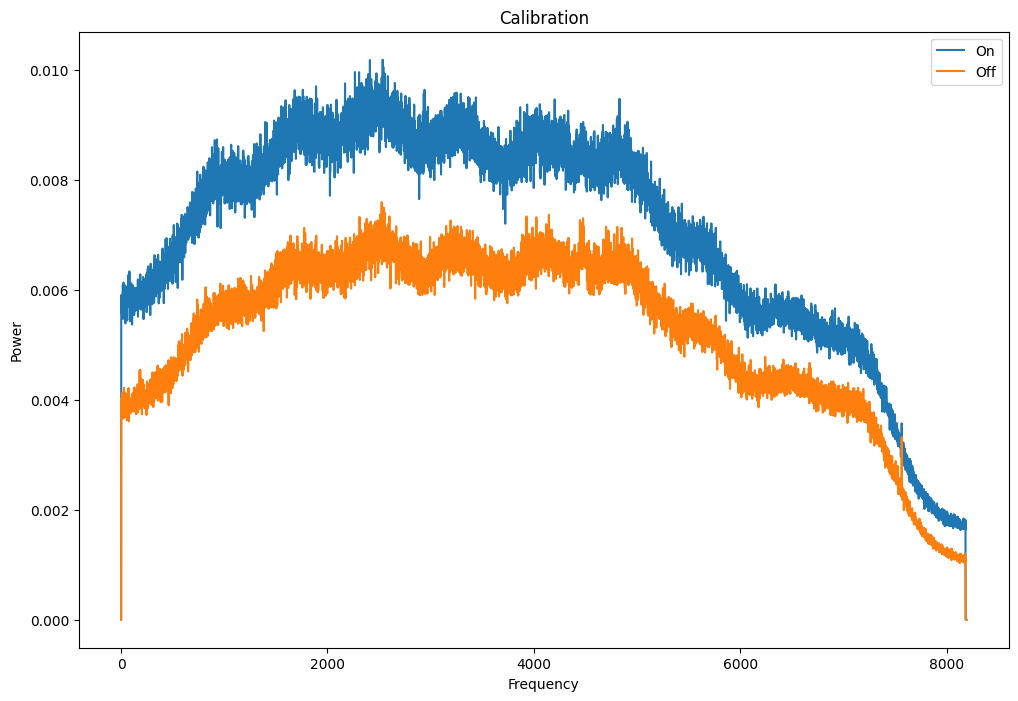

In [90]:
i = 1
s_line = diode_on[i].data['auto0_real']
diode_off_first_polarization = diode_off[i].data['auto0_real']

plt.figure(figsize=(12,8))
plt.plot(s_line, label='On')
plt.plot(diode_off_first_polarization, label='Off')
plt.legend()
plt.title('Calibration')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

## Gain

In [91]:
len(diode_on)

11

In [142]:
# note this gain is only for a specfic (l,b). we could possibly avg more points together to refine the gain value

def calc_gain(s_cal, s_cold):
    T_cal = 79  # K
    T_cold = 20

    gain = (T_cal - T_cold) / np.mean(s_cal - s_cold)
    return gain

gains_list = []
for i in range(1, len(diode_on)):
    s_cal =  diode_on[i].data['auto0_real']
    s_cold = diode_off[i].data['auto0_real']
    gains_list += [calc_gain(s_cal, s_cold)]
print(gains_list)

G_1 = np.mean(gains_list)
print(G_1)

[32883.355443745946, 18952.856063227013, 18953.873709628264, 18958.797488492328, 18979.375078769477, 18995.230819658424, 19034.59277203608, 18992.717662383402, 19032.741486015206, 19052.672778030315]
20383.621330198643


# Temp Graph

In [153]:
orion_data_dir = '../data/4_22/'
sorted_files = np.sort(glob(f'{orion_data_dir}*'))
sorted_files = np.array(sorted_files)

orion_data_files = sorted_files[np.array([re.findall('.*take2.*', f) != [] for f in sorted_files])]

i = 0
orion_data = fits.open(orion_data_files[i])

num_chs = orion_data[0].header['NCHAN*'][0]
samp_rate = orion_data[0].header['SAMPRATE*'][0]
freqs = np.fft.fftshift(np.fft.fftfreq(num_chs, 1/(samp_rate))) + LO # correct for LO
freqs = freqs * 2 + 150e6 # correct for leusch-specific frequency adjustment
orion_data[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                   10 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

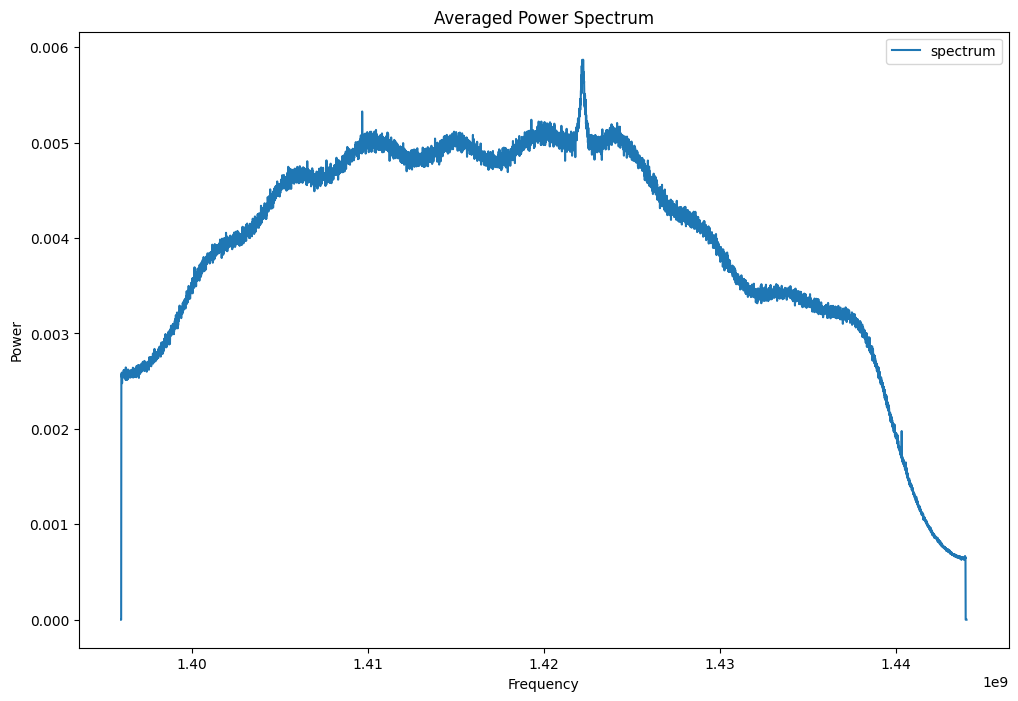

In [252]:
# note this power is only 1 spectrum. we could avg power across all 10 spectra for this point

P_spectra = np.array([np.array(orion_data[i].data['auto0_real']) for i in range(1, len(orion_data))])
s_line = np.mean(P_spectra, axis=0)

plt.figure(figsize=(12,8))
plt.plot(freqs, s_line, label='spectrum')
plt.legend()
plt.title('Averaged Power Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Power')
# plt.xlim(1.4e9, 1.44e9)
plt.show()

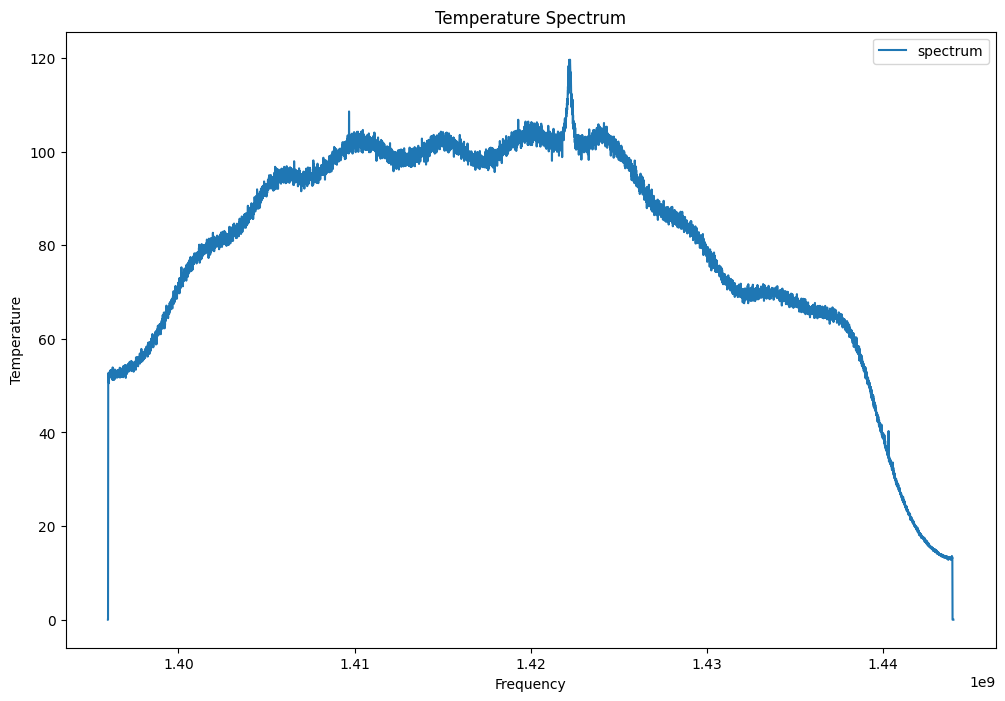

In [253]:
T_line = np.multiply(s_line, G_1)

plt.figure(figsize=(12,8))
plt.plot(freqs, T_line, label='spectrum')
plt.legend()
plt.title('Temperature Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Temperature')
plt.show()

## deconvolution

needs improvement to isolate 21cm line more clearly

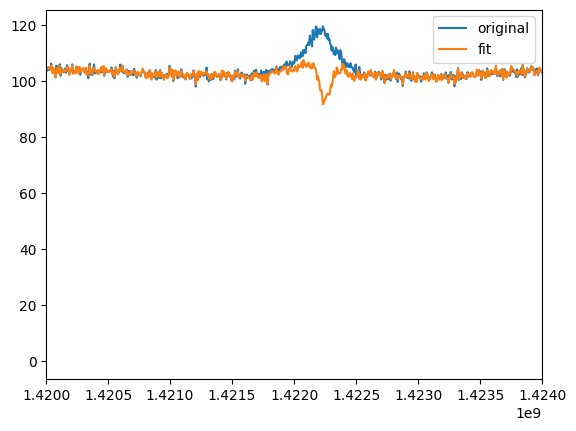

In [263]:
data = T_line.copy()
peak_freq = freqs[np.argmax(data)]
mask = np.where(np.abs(freqs - peak_freq) < 0.3e6, 0, 1)

_data = np.fft.rfft(data * mask)
_dmdl = np.zeros_like(_data)
_mask = np.fft.rfft(mask)
for cnt in range(2000):
    i = np.argmax(np.abs(_data))
    _dmdl[i] += _data[i] / (_mask[0] / mask.size)
    dmdl = np.fft.irfft(_dmdl)
    _data = np.fft.rfft((data - dmdl) * mask)
    
plt.figure()
plt.plot(freqs, data, label='original')
plt.plot(freqs, dmdl, label='fit')

# plt.plot(np.abs(_data))
# plt.plot(np.abs(_mask))

plt.xlim(1.420e9, 1.424e9)
plt.legend()

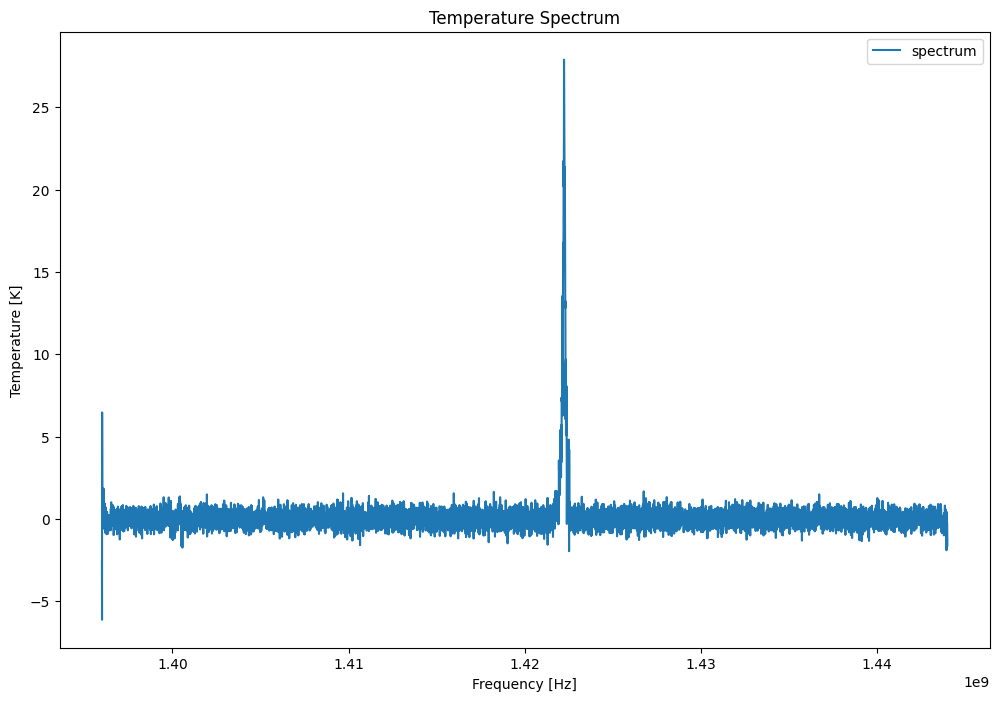

In [264]:
T_line_adj = data - dmdl

plt.figure(figsize=(12,8))
plt.plot(freqs, T_line_adj, label='spectrum')
plt.legend()
plt.title('Temperature Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Temperature [K]')
plt.show()

## Fit Gauss

In [347]:
x_data = freqs
T21 = T_line_adj
ans2, cov2 = ugradio.gauss.gaussfit(x_data, T21, amp=[25,30], avg=[1422e6,1422.4e6], sig=[1e5,1e5], return_cov=True)
profile2 = ugradio.gauss.gaussval(x_data, **ans2)
TSYS = np.sum([cov2[i, i] for i in range(len(cov2))])

0.0808229099129825

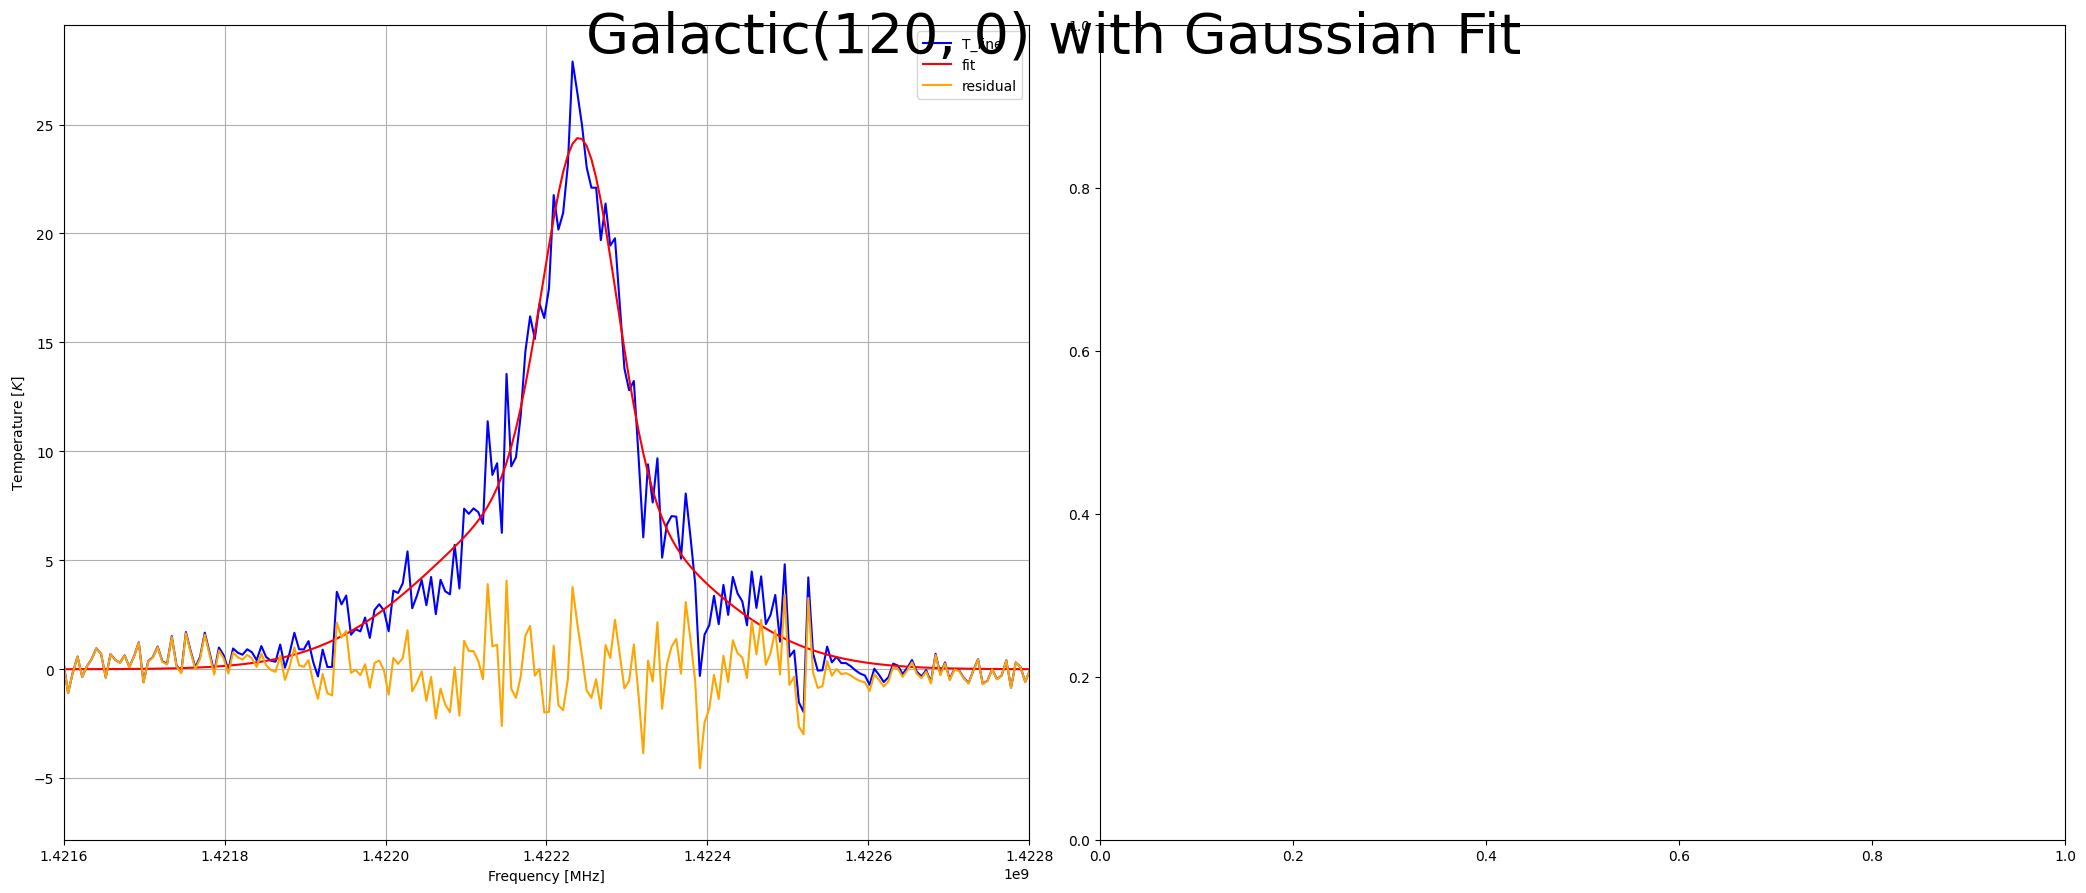

In [323]:
fig, axs = plt.subplots(1, 2,  figsize=(21, 9))
fig.tight_layout(pad=2.0)
fig.suptitle('Galactic(120, 0) with Gaussian Fit', fontsize=40)

plt0 = axs[0]
plt0.plot(x_data, T21, color='blue', label='T_line')
plt0.plot(x_data, profile2, color='red', label='fit')
plt0.plot(freqs, T21 - profile2, color='orange', label='residual')
plt0.set_xlabel('Frequency [MHz]')
plt0.set_ylabel('Temperature [$K$]')
plt0.legend()
plt0.set_xlim(1421.6e6, 1422.8e6)
_ = plt0.grid()

# plt1 = axs[1]
# plt1.plot(v_domain * 10**-3 , T21, color='blue', label='T_line')
# plt1.plot(v_domain * 10**-3, profile2, color='red', label='fit')
# plt1.plot(v_domain * 10**-3, T21 - profile2, color='orange', label='residual')
# plt1.set_xlabel('Velocity [$km/s$]')
# plt1.set_ylabel('Temperature [$K$]')
# plt1.legend()
# _ = plt1.grid()

# Pipeline

In [348]:
def deconvolve(x_data, y_data):
    data = y_data
    peak_freq = x_data[np.argmax(data)]
    mask = np.where(np.abs(x_data - peak_freq) < 0.3e6, 0, 1)

    _data = np.fft.rfft(data * mask)
    _dmdl = np.zeros_like(_data)
    _mask = np.fft.rfft(mask)
    for cnt in range(5000):
        i = np.argmax(np.abs(_data))
        _dmdl[i] += _data[i] / (_mask[0] / mask.size)
        dmdl = np.fft.irfft(_dmdl)
        _data = np.fft.rfft((data - dmdl) * mask)
    
    return dmdl

def fit_gauss(x_data, y_data):
    y_max = max(y_data)
    x_where_y_max = x_data[np.argmax(y_data)]
    ans2, cov2 = ugradio.gauss.gaussfit(x_data, y_data, amp=[y_max-15, y_max], avg=[x_where_y_max-.5e6, x_where_y_max+.5e6], sig=[1e5,1e6], return_cov=True)
    profile2 = ugradio.gauss.gaussval(x_data, **ans2)
    TSYS = np.sum([cov2[i, i] for i in range(len(cov2))])
    return profile2, cov2

def calc_temp(fits_file):
    '''
    returns temperature
    '''

    num_chs = fits_file[0].header['NCHAN*'][0]
    samp_rate = fits_file[0].header['SAMPRATE*'][0]
    freqs = np.fft.fftshift(np.fft.fftfreq(num_chs, 1/(samp_rate))) + LO # correct for LO
    freqs = freqs * 2 + 150e6 # correct for leusch-specific frequency adjustment

    P_spectra = np.array([np.array(fits_file[i].data['auto0_real']) for i in range(1, len(fits_file))])
    s_line = np.mean(P_spectra, axis=0)    
    T_line = np.multiply(s_line, G_1)
    
    decon = deconvolve(freqs, T_line)
    T_line_decon = T_line - decon
    T_line_gauss, T_line_cov = fit_gauss(freqs, T_line_decon)
    result_temp = max(T_line_gauss)
    return result_temp, T_line_cov[0,0]

orion_data_dir = '../data/4_22/'
sorted_files = np.sort(glob(f'{orion_data_dir}*'))
sorted_files = np.array(sorted_files)

orion_data_files = sorted_files[np.array([re.findall('.*take2.*', f) != [] for f in sorted_files])]

for i in [1,170,457,578,667]:
    orion_data = fits.open(orion_data_files[i])

    print(calc_temp(orion_data))

(25.423340550352997, 0.007309269461479236)
(18.03172826378854, 0.040252651187479005)
(25.268087606790097, 0.017768921634334533)
(23.124413710858715, 0.009730506837032906)
(22.769604797757165, 0.0055123046031920146)


notes, ideas

- possibly use the non-take2 data

- double check the spectra + gauss fits, maybe plot some random ones to make sure
- need error bars: chi sq for gaussian fits
- need velocities
- make imshow plot -> send it

- consider calculating gain for each point? 

# Map

In [ ]:
_LO = 1270
freqs = np.linspace(144,156,8192) + _LO

# other

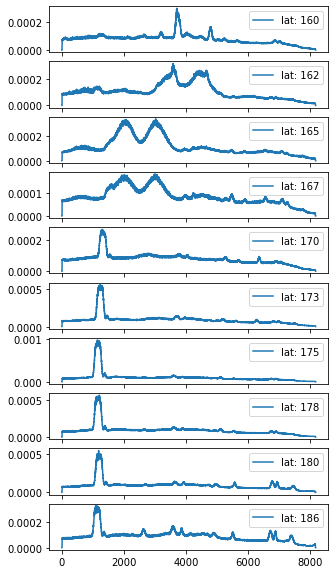

In [70]:
mask41 = ['-40.0.fits' in file for file in sorted_files] 
n = 10
fig, ax = plt.subplots(n, figsize=(5, 10), sharex=True)


for i, fname in enumerate(sorted_files[mask41][:10]):
    f = fits.open(fname)
    l = fname.split('.')[1].split('_')[1]
    first_polarization = f[1].data['auto0_real']
    ax[i].plot(first_polarization, label=f'lat: {l}')
    ax[i].legend()
    
# plt.show()

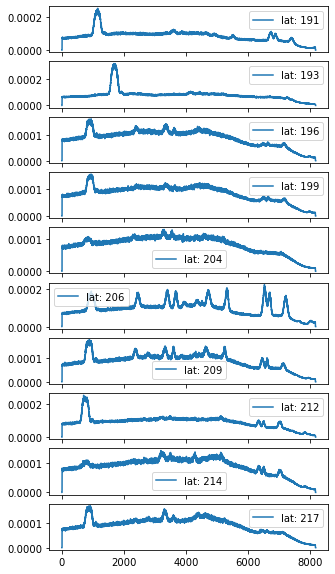

In [71]:
mask41 = ['-40.0.fits' in file for file in sorted_files] 
n = 10
fig, ax = plt.subplots(n, figsize=(5, 10), sharex=True)


for i, fname in enumerate(sorted_files[mask41][11:]):
    f = fits.open(fname)
    l = fname.split('.')[1].split('_')[1]
    first_polarization = f[1].data['auto0_real']
    ax[i].plot(first_polarization, label=f'lat: {l}')
    ax[i].legend()
    
# plt.show()

/home/zoeko/astro121lab/lab4/data/1681982046.2315152_160.0_-70.0.fits


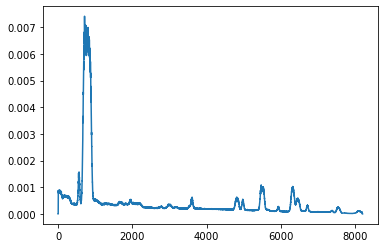

/home/zoeko/astro121lab/lab4/data/1681982067.2297876_165.84760880032619_-70.0.fits


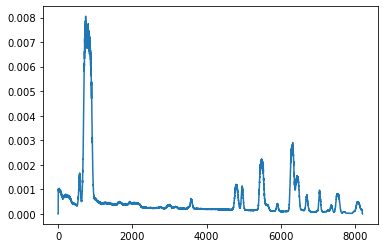

/home/zoeko/astro121lab/lab4/data/1681982083.289589_171.69521760065237_-70.0.fits


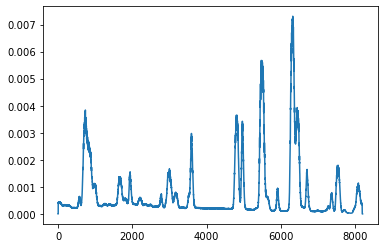

/home/zoeko/astro121lab/lab4/data/1681982100.7808354_177.54282640097856_-70.0.fits


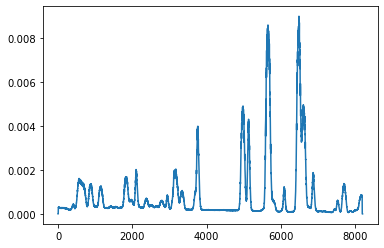

/home/zoeko/astro121lab/lab4/data/1681982118.2324886_183.39043520130474_-70.0.fits


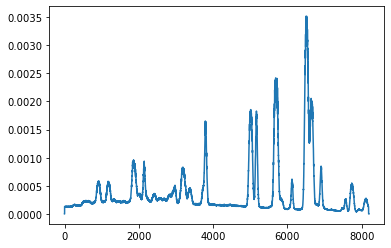

/home/zoeko/astro121lab/lab4/data/1681982135.6898706_189.23804400163093_-70.0.fits


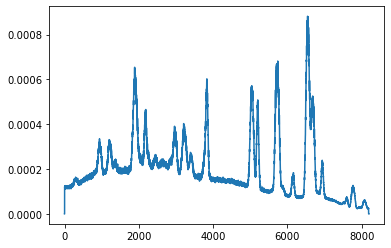

/home/zoeko/astro121lab/lab4/data/1681982153.2302802_195.0856528019571_-70.0.fits


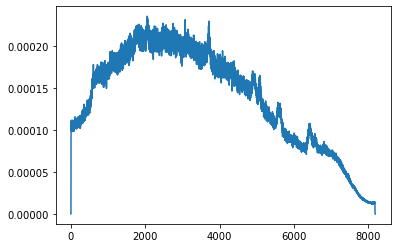

/home/zoeko/astro121lab/lab4/data/1681982170.6910117_200.9332616022833_-70.0.fits


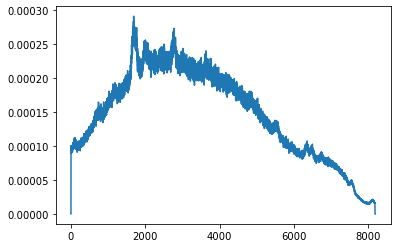

/home/zoeko/astro121lab/lab4/data/1681982188.1658516_206.78087040260948_-70.0.fits


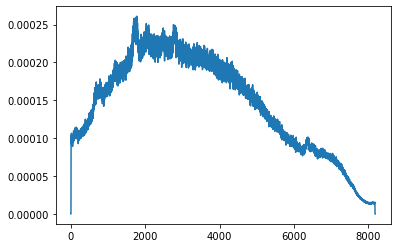

/home/zoeko/astro121lab/lab4/data/1681982205.6612272_212.62847920293567_-70.0.fits


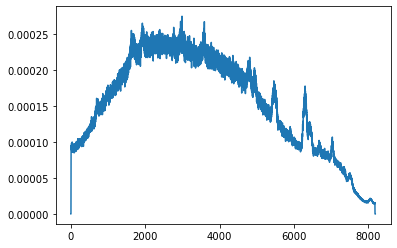

/home/zoeko/astro121lab/lab4/data/1681982221.7634897_218.47608800326185_-70.0.fits


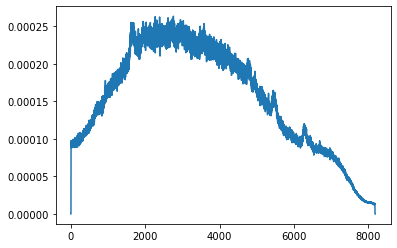

/home/zoeko/astro121lab/lab4/data/1681982237.8217897_160.0_-68.0.fits


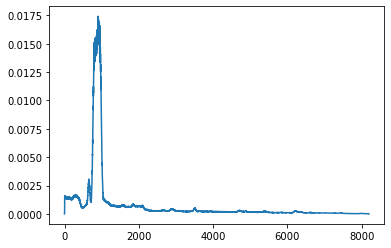

/home/zoeko/astro121lab/lab4/data/1681982280.4510336_165.33893432510803_-68.0.fits


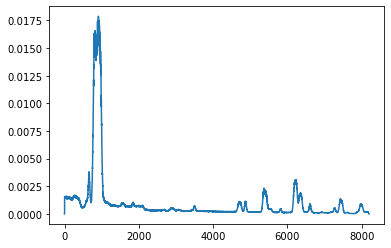

/home/zoeko/astro121lab/lab4/data/1681982296.4859102_170.67786865021606_-68.0.fits


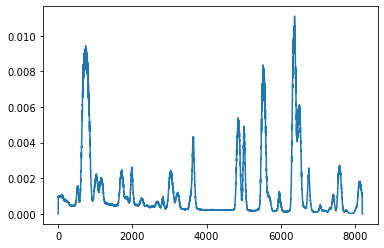

/home/zoeko/astro121lab/lab4/data/1681982313.9702756_176.01680297532408_-68.0.fits


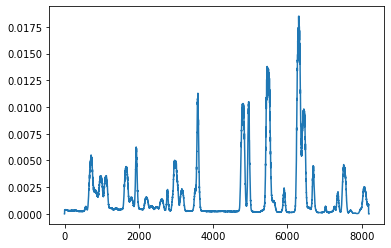

/home/zoeko/astro121lab/lab4/data/1681982331.4732285_181.3557373004321_-68.0.fits


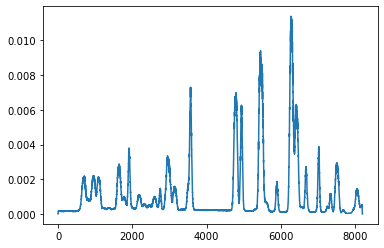

/home/zoeko/astro121lab/lab4/data/1681982348.9798098_186.69467162554014_-68.0.fits


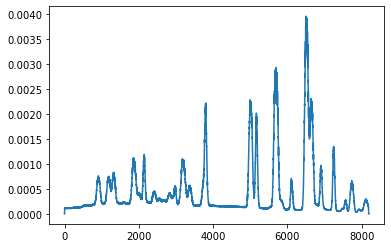

/home/zoeko/astro121lab/lab4/data/1681982366.4423544_192.03360595064817_-68.0.fits


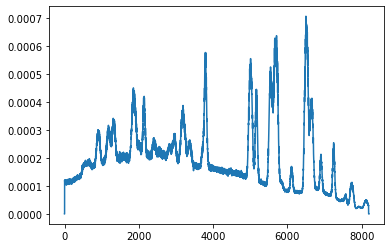

/home/zoeko/astro121lab/lab4/data/1681982383.8996818_197.3725402757562_-68.0.fits


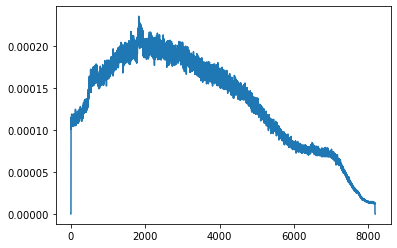

/home/zoeko/astro121lab/lab4/data/1681982401.4089506_202.71147460086422_-68.0.fits


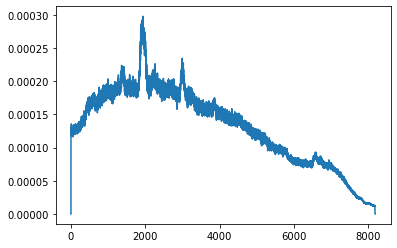

/home/zoeko/astro121lab/lab4/data/1681982418.8705313_208.05040892597225_-68.0.fits


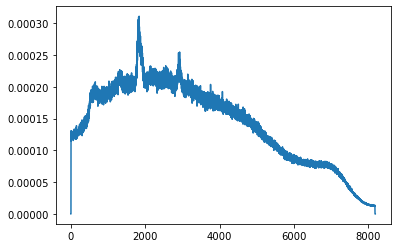

/home/zoeko/astro121lab/lab4/data/1681982436.3295064_213.38934325108028_-68.0.fits


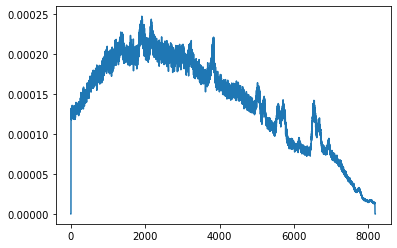

/home/zoeko/astro121lab/lab4/data/1681982452.4400337_218.7282775761883_-68.0.fits


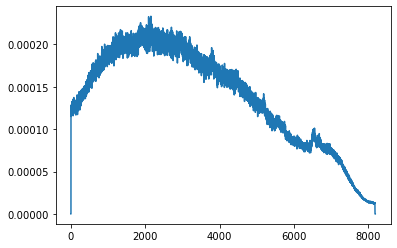

/home/zoeko/astro121lab/lab4/data/1681982468.480411_160.0_-66.0.fits


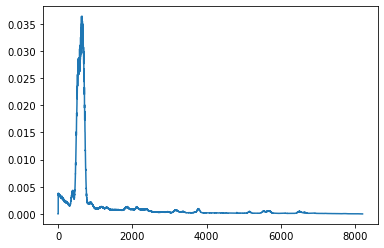

/home/zoeko/astro121lab/lab4/data/1681982514.693437_164.91718667114847_-66.0.fits


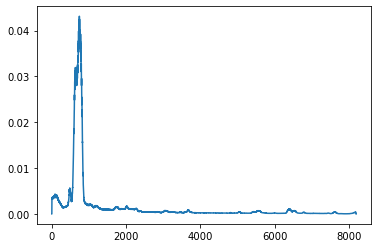

/home/zoeko/astro121lab/lab4/data/1681982530.6925528_169.83437334229694_-66.0.fits


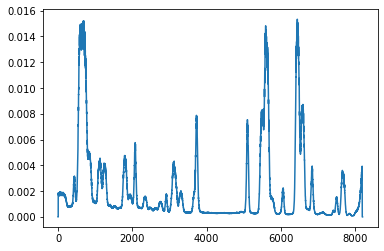

/home/zoeko/astro121lab/lab4/data/1681982548.1721497_174.7515600134454_-66.0.fits


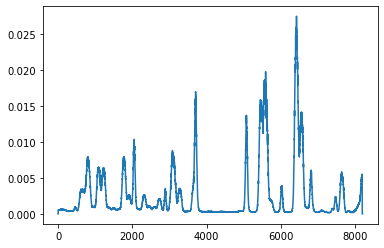

/home/zoeko/astro121lab/lab4/data/1681982565.6721213_179.66874668459388_-66.0.fits


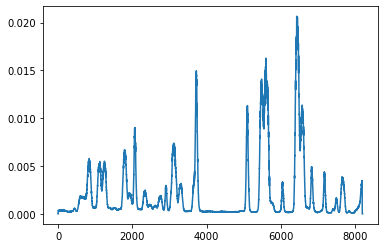

/home/zoeko/astro121lab/lab4/data/1681982583.14329_184.58593335574236_-66.0.fits


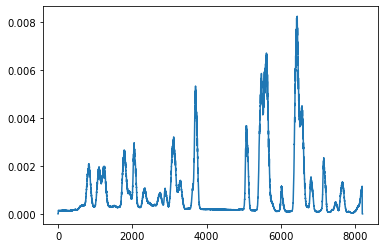

/home/zoeko/astro121lab/lab4/data/1681982600.5812173_189.50312002689083_-66.0.fits


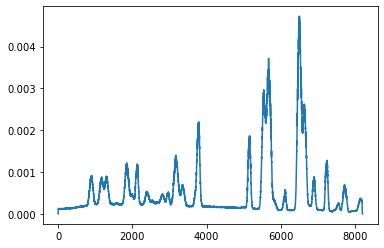

/home/zoeko/astro121lab/lab4/data/1681982618.0929177_194.4203066980393_-66.0.fits


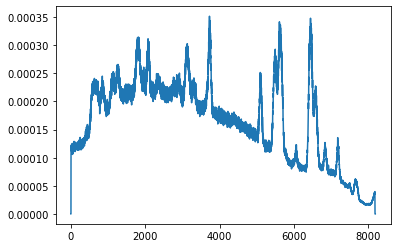

/home/zoeko/astro121lab/lab4/data/1681982635.5807967_199.33749336918777_-66.0.fits


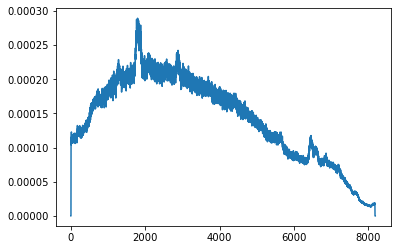

/home/zoeko/astro121lab/lab4/data/1681982653.0504823_204.25468004033624_-66.0.fits


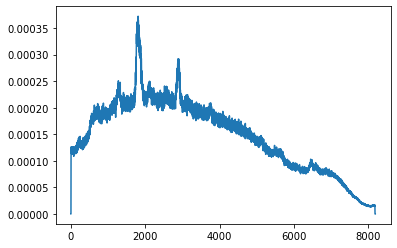

/home/zoeko/astro121lab/lab4/data/1681982670.5335505_209.1718667114847_-66.0.fits


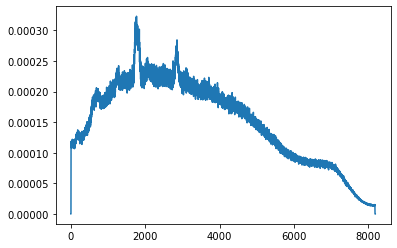

/home/zoeko/astro121lab/lab4/data/1681982688.0190983_214.08905338263318_-66.0.fits


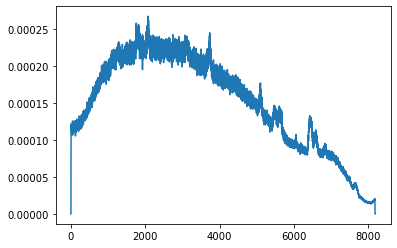

/home/zoeko/astro121lab/lab4/data/1681982704.0662367_219.00624005378165_-66.0.fits


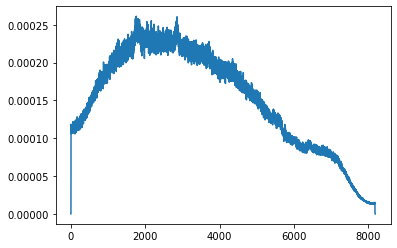

/home/zoeko/astro121lab/lab4/data/1681982720.1497774_160.0_-64.0.fits


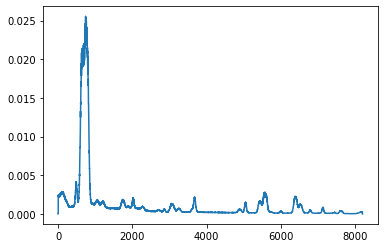

/home/zoeko/astro121lab/lab4/data/1681982768.4212952_164.56234406540972_-64.0.fits


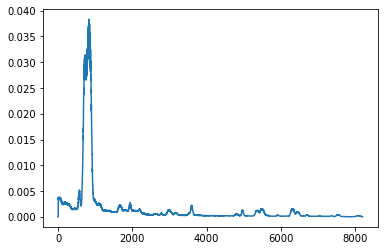

/home/zoeko/astro121lab/lab4/data/1681982784.4393635_169.12468813081944_-64.0.fits


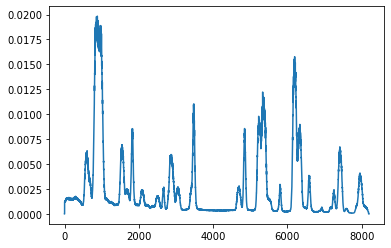

/home/zoeko/astro121lab/lab4/data/1681982801.9296496_173.68703219622915_-64.0.fits


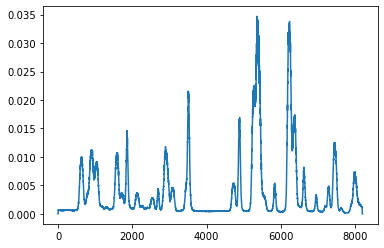

/home/zoeko/astro121lab/lab4/data/1681982819.365544_178.24937626163887_-64.0.fits


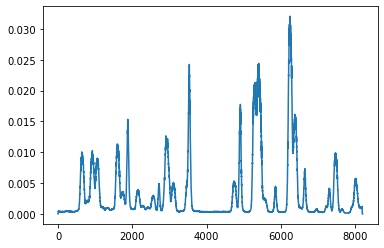

/home/zoeko/astro121lab/lab4/data/1681982836.8538265_182.8117203270486_-64.0.fits


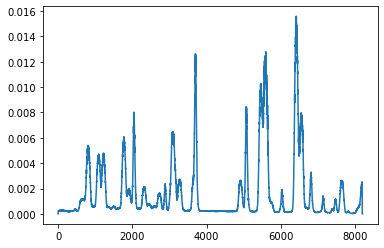

/home/zoeko/astro121lab/lab4/data/1681982854.3964562_187.3740643924583_-64.0.fits


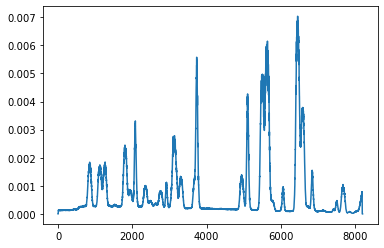

/home/zoeko/astro121lab/lab4/data/1681982871.8099267_191.93640845786803_-64.0.fits


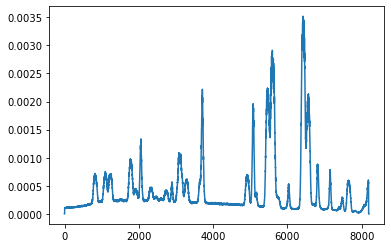

/home/zoeko/astro121lab/lab4/data/1681982889.3136714_196.49875252327774_-64.0.fits


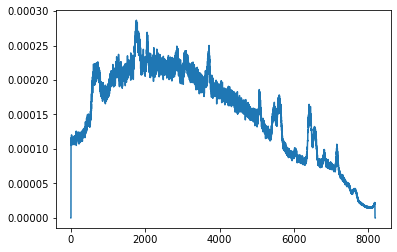

/home/zoeko/astro121lab/lab4/data/1681982906.7717_201.06109658868746_-64.0.fits


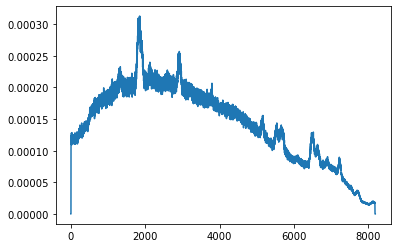

/home/zoeko/astro121lab/lab4/data/1681982924.2521813_205.62344065409718_-64.0.fits


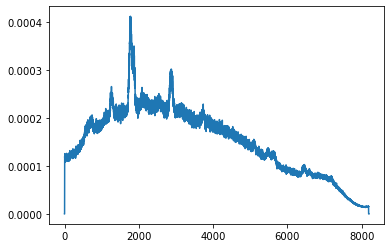

/home/zoeko/astro121lab/lab4/data/1681982941.7593234_210.1857847195069_-64.0.fits


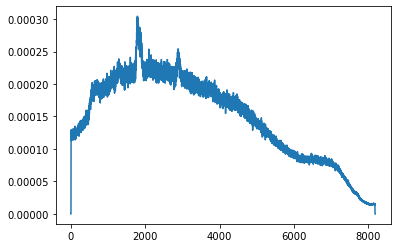

/home/zoeko/astro121lab/lab4/data/1681982959.2142696_214.74812878491662_-64.0.fits


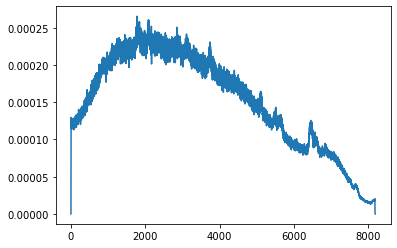

/home/zoeko/astro121lab/lab4/data/1681982975.3397503_219.31047285032633_-64.0.fits


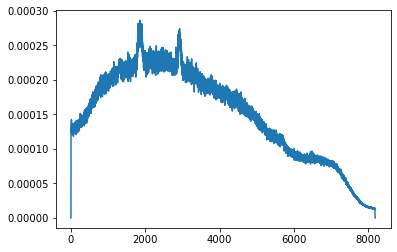

/home/zoeko/astro121lab/lab4/data/1681982991.3671672_160.0_-62.0.fits


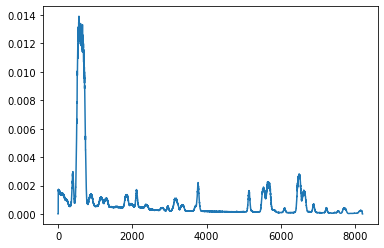

/home/zoeko/astro121lab/lab4/data/1681983043.0870872_164.26010893637903_-62.0.fits


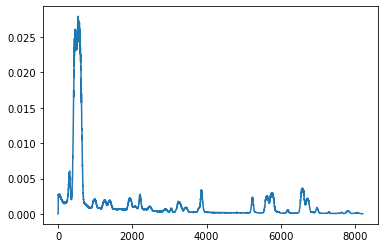

/home/zoeko/astro121lab/lab4/data/1681983059.1798098_168.52021787275805_-62.0.fits


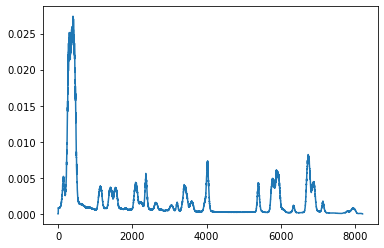

/home/zoeko/astro121lab/lab4/data/1681983076.6470838_172.78032680913708_-62.0.fits


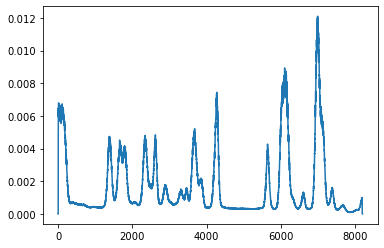

/home/zoeko/astro121lab/lab4/data/1681983094.150235_177.0404357455161_-62.0.fits


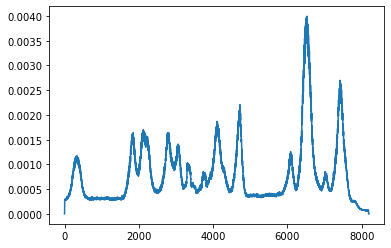

/home/zoeko/astro121lab/lab4/data/1681983111.5912519_181.30054468189513_-62.0.fits


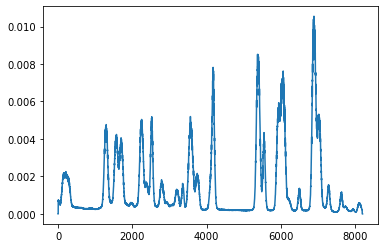

/home/zoeko/astro121lab/lab4/data/1681983129.0938873_185.56065361827416_-62.0.fits


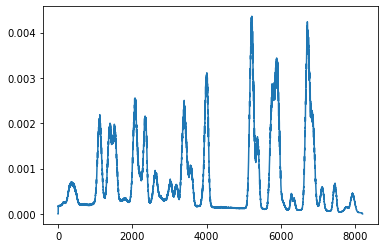

/home/zoeko/astro121lab/lab4/data/1681983146.6091788_189.8207625546532_-62.0.fits


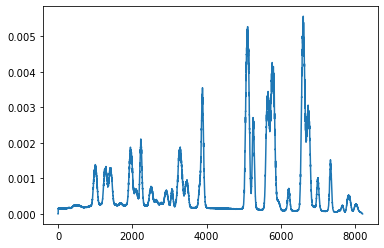

/home/zoeko/astro121lab/lab4/data/1681983164.05965_194.0808714910322_-62.0.fits


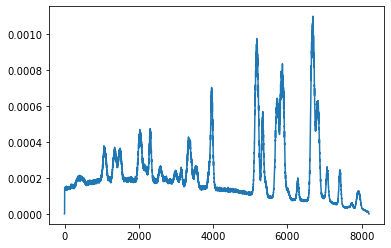

/home/zoeko/astro121lab/lab4/data/1681983181.5552185_198.34098042741124_-62.0.fits


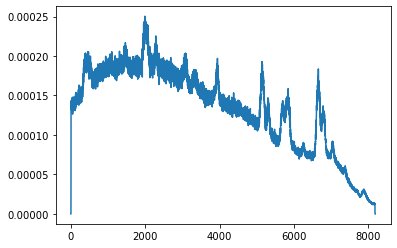

/home/zoeko/astro121lab/lab4/data/1681983199.0068452_202.60108936379027_-62.0.fits


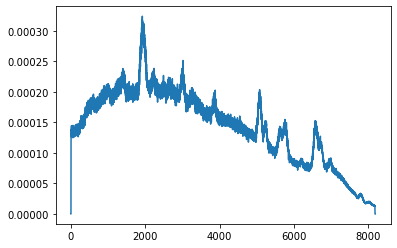

/home/zoeko/astro121lab/lab4/data/1681983216.4806502_206.8611983001693_-62.0.fits


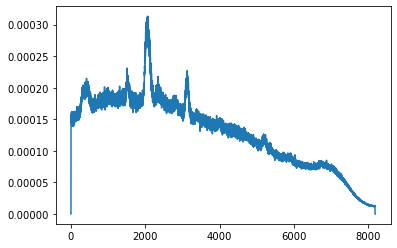

/home/zoeko/astro121lab/lab4/data/1681983233.9895248_211.12130723654832_-62.0.fits


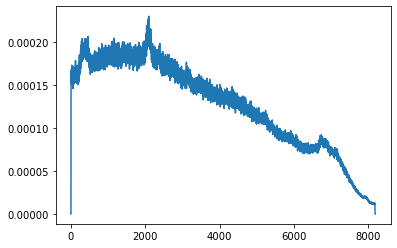

/home/zoeko/astro121lab/lab4/data/1681983251.5610626_215.38141617292735_-62.0.fits


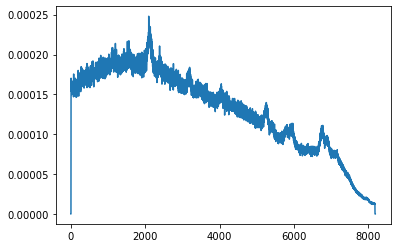

/home/zoeko/astro121lab/lab4/data/1681983267.519268_219.64152510930637_-62.0.fits


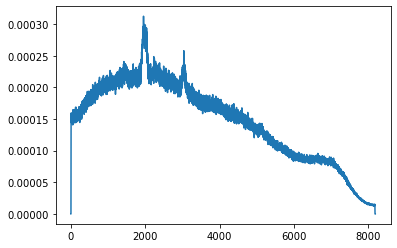

/home/zoeko/astro121lab/lab4/data/1681983283.573478_160.0_-60.0.fits


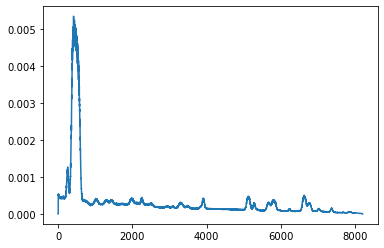

/home/zoeko/astro121lab/lab4/data/1681983338.1010916_164.0_-60.0.fits


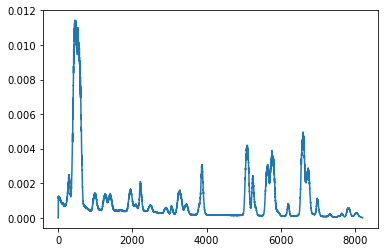

/home/zoeko/astro121lab/lab4/data/1681983354.240759_168.0_-60.0.fits


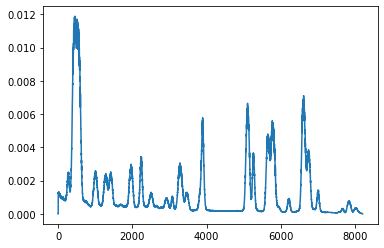

/home/zoeko/astro121lab/lab4/data/1681983371.6812022_172.0_-60.0.fits


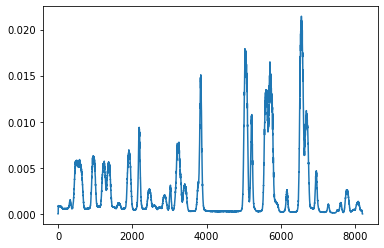

/home/zoeko/astro121lab/lab4/data/1681983389.1618328_176.0_-60.0.fits


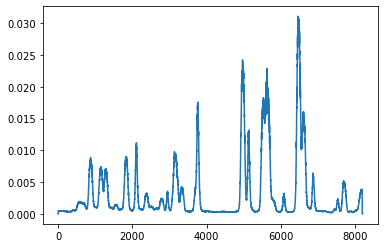

/home/zoeko/astro121lab/lab4/data/1681983406.610722_180.0_-60.0.fits


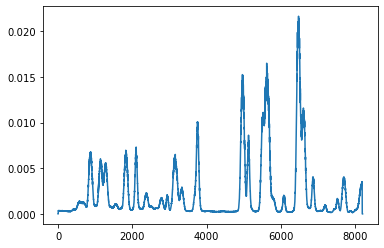

/home/zoeko/astro121lab/lab4/data/1681983424.0641055_184.0_-60.0.fits


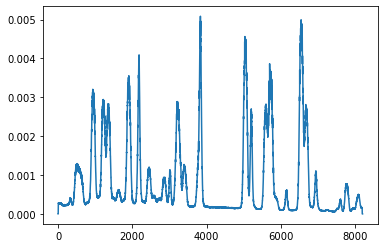

/home/zoeko/astro121lab/lab4/data/1681983441.5789053_188.0_-60.0.fits


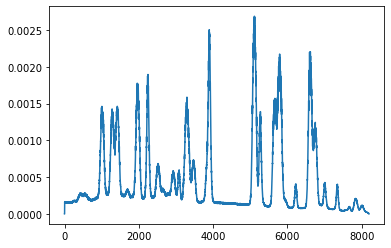

/home/zoeko/astro121lab/lab4/data/1681983459.1106873_192.0_-60.0.fits


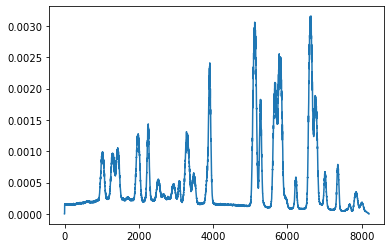

/home/zoeko/astro121lab/lab4/data/1681983476.5506418_196.0_-60.0.fits


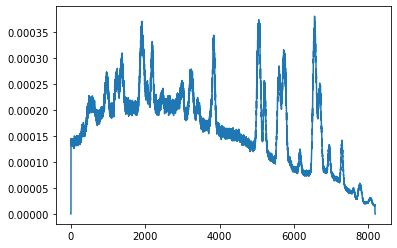

/home/zoeko/astro121lab/lab4/data/1681983493.9792738_200.0_-60.0.fits


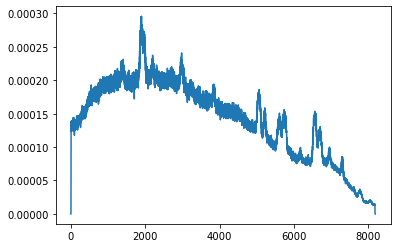

/home/zoeko/astro121lab/lab4/data/1681983511.5123773_204.0_-60.0.fits


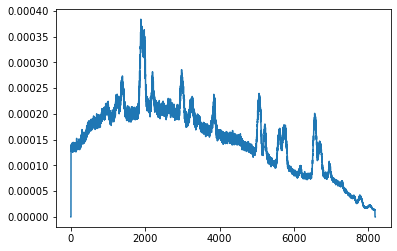

/home/zoeko/astro121lab/lab4/data/1681983528.9443848_208.0_-60.0.fits


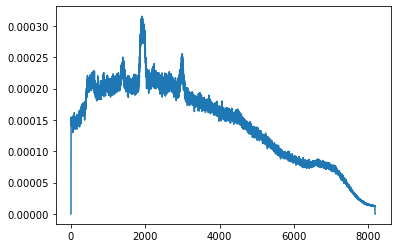

/home/zoeko/astro121lab/lab4/data/1681983546.418298_212.0_-60.0.fits


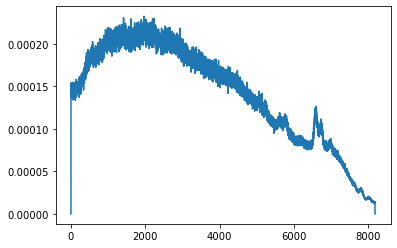

/home/zoeko/astro121lab/lab4/data/1681983563.87914_216.0_-60.0.fits


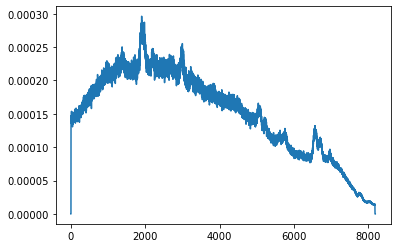

/home/zoeko/astro121lab/lab4/data/1681983579.950874_220.0_-60.0.fits


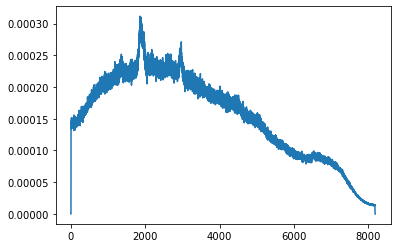

/home/zoeko/astro121lab/lab4/data/1681983596.0768168_160.0_-58.0.fits


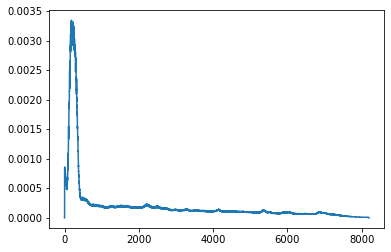

/home/zoeko/astro121lab/lab4/data/1681983653.4031637_163.7741598295997_-58.0.fits


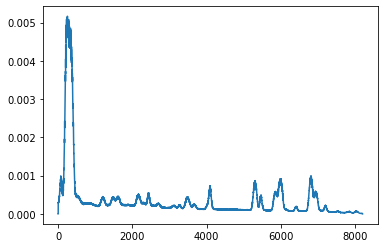

/home/zoeko/astro121lab/lab4/data/1681983669.4561226_167.54831965919942_-58.0.fits


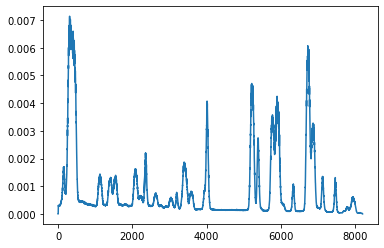

/home/zoeko/astro121lab/lab4/data/1681983686.9595606_171.32247948879913_-58.0.fits


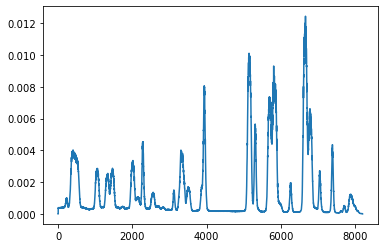

/home/zoeko/astro121lab/lab4/data/1681983704.3904548_175.09663931839884_-58.0.fits


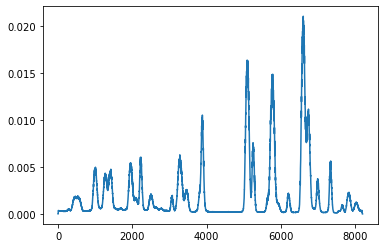

/home/zoeko/astro121lab/lab4/data/1681983721.8553417_178.87079914799855_-58.0.fits


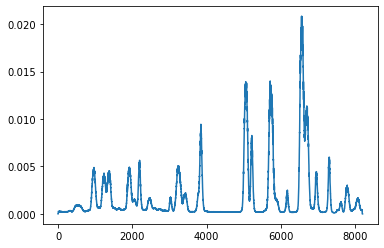

/home/zoeko/astro121lab/lab4/data/1681983739.3209503_182.64495897759826_-58.0.fits


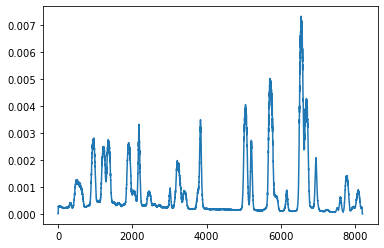

/home/zoeko/astro121lab/lab4/data/1681983756.8035893_186.41911880719798_-58.0.fits


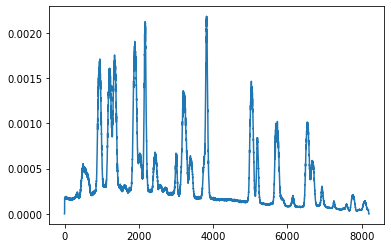

/home/zoeko/astro121lab/lab4/data/1681983774.3149297_190.1932786367977_-58.0.fits


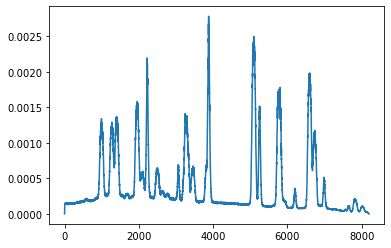

/home/zoeko/astro121lab/lab4/data/1681983791.8108194_193.9674384663974_-58.0.fits


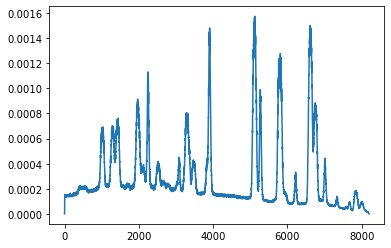

/home/zoeko/astro121lab/lab4/data/1681983809.2710533_197.7415982959971_-58.0.fits


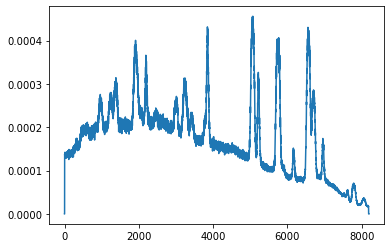

/home/zoeko/astro121lab/lab4/data/1681983826.7311878_201.51575812559682_-58.0.fits


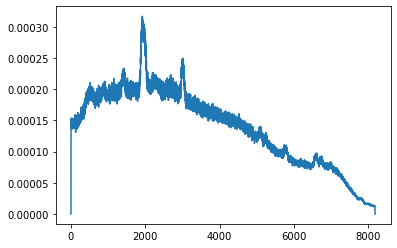

/home/zoeko/astro121lab/lab4/data/1681983844.2244506_205.28991795519653_-58.0.fits


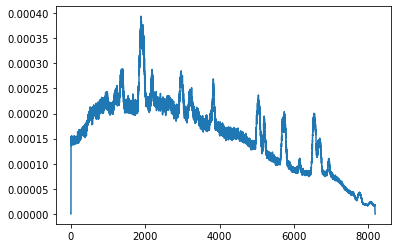

/home/zoeko/astro121lab/lab4/data/1681983861.7009604_209.06407778479624_-58.0.fits


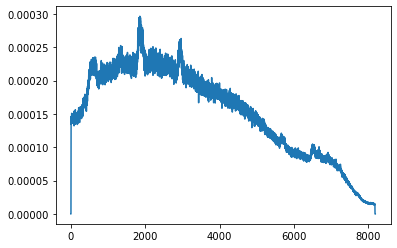

/home/zoeko/astro121lab/lab4/data/1681983879.1699066_212.83823761439595_-58.0.fits


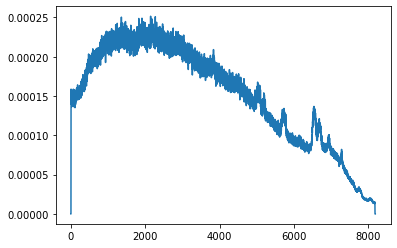

/home/zoeko/astro121lab/lab4/data/1681983895.2211618_216.61239744399566_-58.0.fits


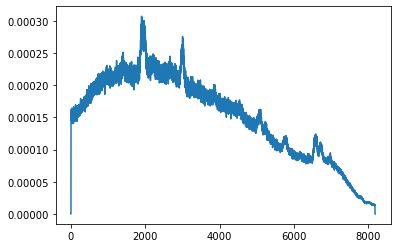

/home/zoeko/astro121lab/lab4/data/1681983911.3306692_160.0_-56.0.fits


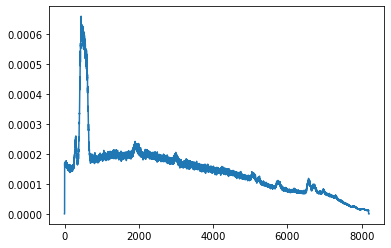

/home/zoeko/astro121lab/lab4/data/1681983969.35054_163.5765832999428_-56.0.fits


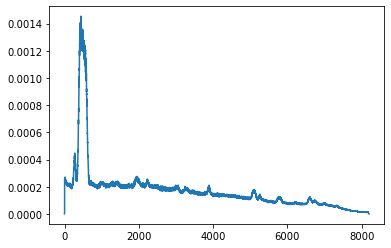

/home/zoeko/astro121lab/lab4/data/1681983985.400912_167.1531665998856_-56.0.fits


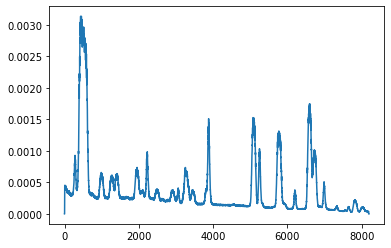

/home/zoeko/astro121lab/lab4/data/1681984002.9295332_170.7297498998284_-56.0.fits


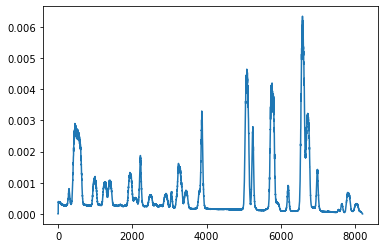

/home/zoeko/astro121lab/lab4/data/1681984020.371157_174.3063331997712_-56.0.fits


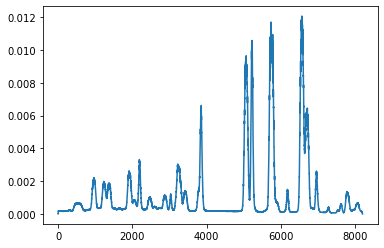

/home/zoeko/astro121lab/lab4/data/1681984037.8309162_177.88291649971399_-56.0.fits


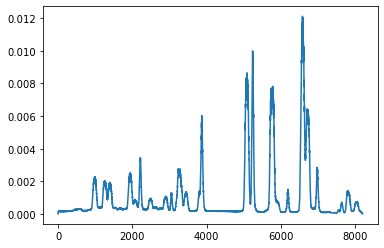

/home/zoeko/astro121lab/lab4/data/1681984055.341228_181.45949979965678_-56.0.fits


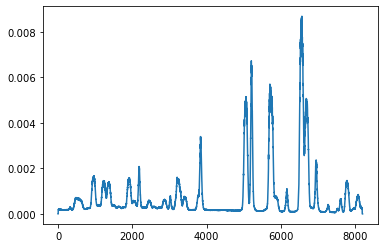

/home/zoeko/astro121lab/lab4/data/1681984072.799545_185.03608309959958_-56.0.fits


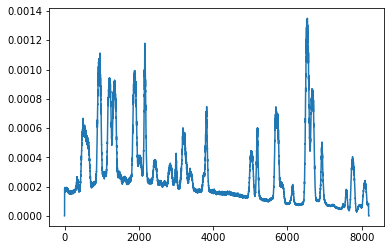

/home/zoeko/astro121lab/lab4/data/1681984090.3310816_188.61266639954238_-56.0.fits


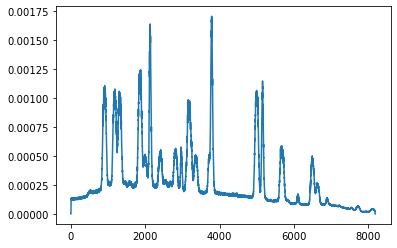

/home/zoeko/astro121lab/lab4/data/1681984107.7901995_192.18924969948517_-56.0.fits


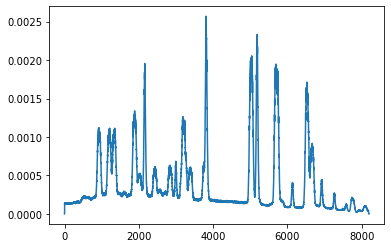

/home/zoeko/astro121lab/lab4/data/1681984125.2606518_195.76583299942797_-56.0.fits


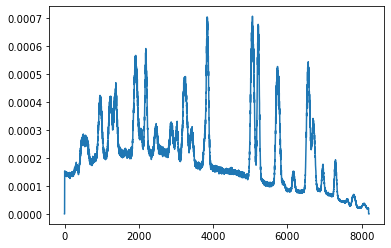

/home/zoeko/astro121lab/lab4/data/1681984142.7202568_199.34241629937077_-56.0.fits


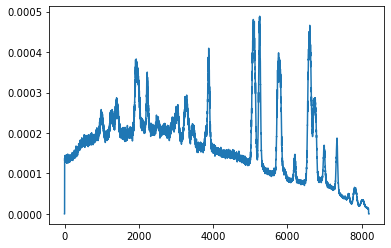

/home/zoeko/astro121lab/lab4/data/1681984160.1704497_202.91899959931357_-56.0.fits


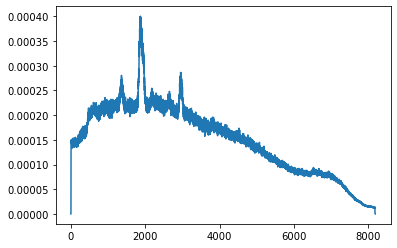

/home/zoeko/astro121lab/lab4/data/1681984180.1953557_206.49558289925636_-56.0.fits


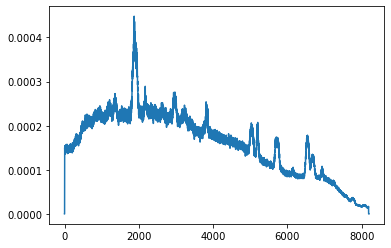

/home/zoeko/astro121lab/lab4/data/1681984197.641643_210.07216619919916_-56.0.fits


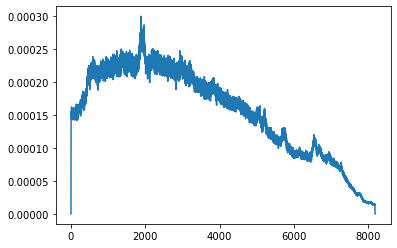

/home/zoeko/astro121lab/lab4/data/1681984215.0816646_213.64874949914196_-56.0.fits


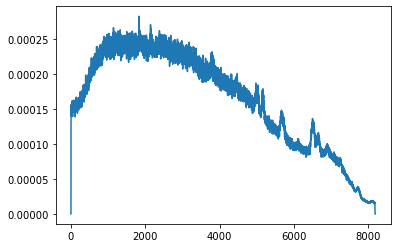

/home/zoeko/astro121lab/lab4/data/1681984231.2389688_217.22533279908475_-56.0.fits


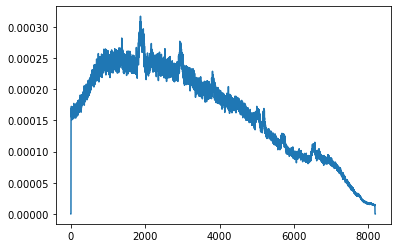

/home/zoeko/astro121lab/lab4/data/1681984247.270625_160.0_-54.0.fits


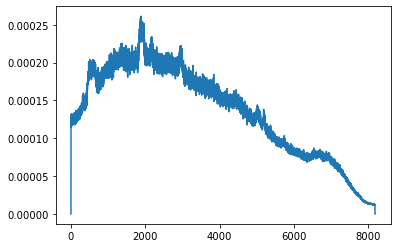

/home/zoeko/astro121lab/lab4/data/1681984308.7913754_163.40260323340817_-54.0.fits


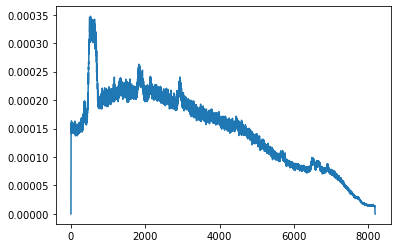

/home/zoeko/astro121lab/lab4/data/1681984324.8722882_166.80520646681634_-54.0.fits


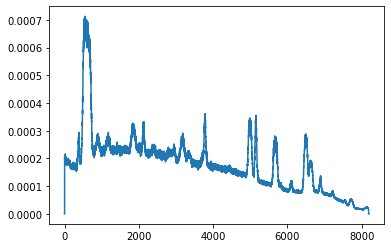

/home/zoeko/astro121lab/lab4/data/1681984342.3255782_170.20780970022452_-54.0.fits


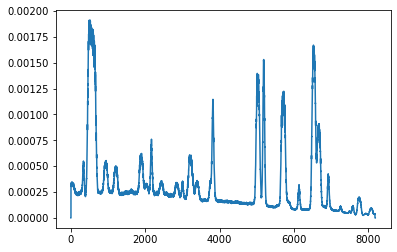

/home/zoeko/astro121lab/lab4/data/1681984359.8596473_173.6104129336327_-54.0.fits


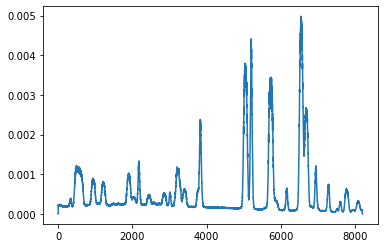

/home/zoeko/astro121lab/lab4/data/1681984377.35114_177.01301616704086_-54.0.fits


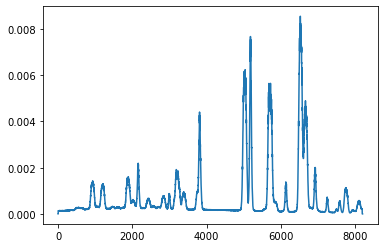

/home/zoeko/astro121lab/lab4/data/1681984397.3345773_180.41561940044903_-54.0.fits


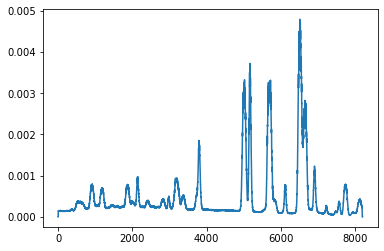

/home/zoeko/astro121lab/lab4/data/1681984414.859401_183.8182226338572_-54.0.fits


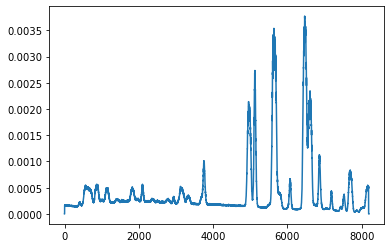

/home/zoeko/astro121lab/lab4/data/1681984432.2817502_187.22082586726538_-54.0.fits


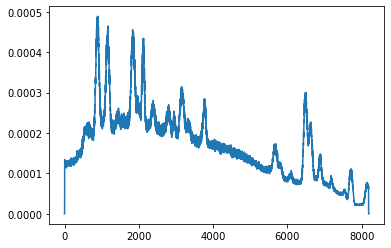

/home/zoeko/astro121lab/lab4/data/1681984449.7989802_190.62342910067355_-54.0.fits


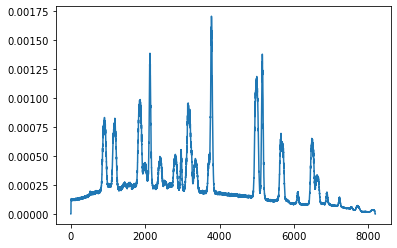

/home/zoeko/astro121lab/lab4/data/1681984467.2624035_194.02603233408172_-54.0.fits


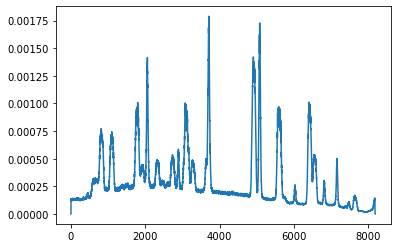

/home/zoeko/astro121lab/lab4/data/1681984484.7059577_197.4286355674899_-54.0.fits


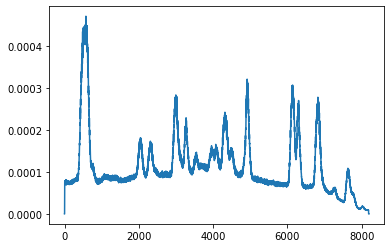

/home/zoeko/astro121lab/lab4/data/1681984502.24019_200.83123880089806_-54.0.fits


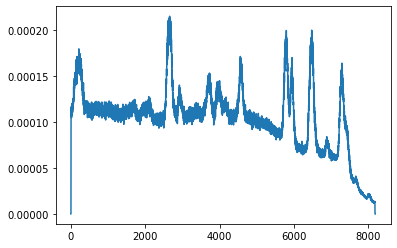

/home/zoeko/astro121lab/lab4/data/1681984519.696874_204.23384203430624_-54.0.fits


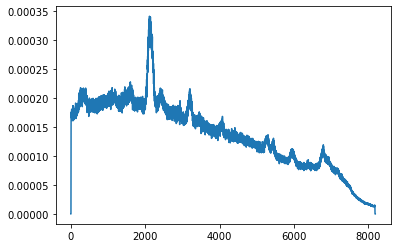

/home/zoeko/astro121lab/lab4/data/1681984537.161363_207.6364452677144_-54.0.fits


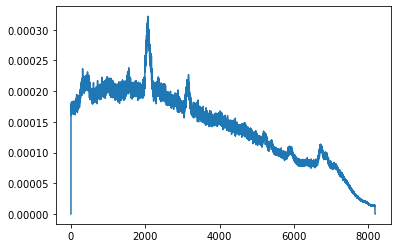

/home/zoeko/astro121lab/lab4/data/CALIBRATION1681981997.0511672_160.0_-70.0


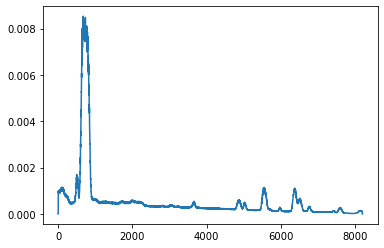

In [23]:
for file in sorted_files:
    if 'orion.log' in file:
        continue
    print(file)
    f = fits.open(file)
    hdr = dict(f[0].header)
    first_polarization = f[1].data['auto0_real']
    plt.plot(first_polarization)
    plt.show()
    
    break